# Feature Engineering

In this chapter learn how to create new features for your machine learning model to learn from. We'll look at generating them by combining fields, extracting values from messy columns or encoding them for better results.

## Preparing the environment

### Importing libraries

In [1]:
import pandas as pd
import seaborn as sns
import sys
import matplotlib.pyplot as plt

from environment import histogram_boxplot, linear_model_plot, labeled_barplot
from typing import List
from pprint import pprint

from pyspark.sql.types import (_parse_datatype_string, StructType, StructField,
                               DoubleType, IntegerType, StringType)
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import Binarizer, Bucketizer, OneHotEncoder, StringIndexer

### Connect to Spark

In [2]:
spark = SparkSession.builder.getOrCreate()

# eval DataFrame in notebooks
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [3]:
sc = spark.sparkContext

### Checking the version of PySpark and Python

In [4]:
print('Spark  version:', spark.version)
print('Python version:', sys.version_info)

Spark  version: 3.5.1
Python version: sys.version_info(major=3, minor=11, micro=9, releaselevel='final', serial=0)


### Loading data

In [5]:
# read file
real_state = spark.read.csv('data-sources/2017_StPaul_MN_Real_Estate.csv', header=True, inferSchema=True)

# cast columns
for col_name in ['SQFTBELOWGROUND', 'AssociationFee']:
    real_state = real_state.withColumn(col_name, real_state[col_name].cast('bigint'))
real_state = real_state.withColumn('backonmarketdate', real_state['backonmarketdate'].cast('double'))
real_state = real_state.withColumn("offmarketdate", 
                                       F.to_timestamp(real_state["offmarketdate"], "M/d/yyyy H:m"))

# save to parquet format
file_path = 'spark-warehouse/real_state.parquet'
real_state.write.parquet(file_path, mode="overwrite")
real_state = spark.read.parquet(file_path)
real_state.createOrReplaceTempView("real_state")
real_state.printSchema()
real_state.limit(2)

root
 |-- No.: integer (nullable = true)
 |-- MLSID: string (nullable = true)
 |-- StreetNumberNumeric: integer (nullable = true)
 |-- streetaddress: string (nullable = true)
 |-- STREETNAME: string (nullable = true)
 |-- PostalCode: integer (nullable = true)
 |-- StateOrProvince: string (nullable = true)
 |-- City: string (nullable = true)
 |-- SalesClosePrice: integer (nullable = true)
 |-- LISTDATE: string (nullable = true)
 |-- LISTPRICE: integer (nullable = true)
 |-- LISTTYPE: string (nullable = true)
 |-- OriginalListPrice: integer (nullable = true)
 |-- PricePerTSFT: double (nullable = true)
 |-- FOUNDATIONSIZE: integer (nullable = true)
 |-- FENCE: string (nullable = true)
 |-- MapLetter: string (nullable = true)
 |-- LotSizeDimensions: string (nullable = true)
 |-- SchoolDistrictNumber: string (nullable = true)
 |-- DAYSONMARKET: integer (nullable = true)
 |-- offmarketdate: timestamp (nullable = true)
 |-- Fireplaces: integer (nullable = true)
 |-- RoomArea4: string (nullabl

No.,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PoolDescription,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,UNITNUMBER,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,backonmarketdate,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,Class,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation
1,RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,NULL,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,NULL,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,SF,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,NULL,NULL,3,0,NULL,0,Unknown,0.0
2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,NULL,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,NULL,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",NULL,Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,SF,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,11x11,Lower,4,960,NULL,0,Unknown,0.0


### Tables catalogue

In [6]:
spark.catalog.listTables()

[Table(name='real_state', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True)]

## Ex. 1 - Differences
Let's explore generating features using existing ones. In the midwest of the U.S. many single family homes have extra land around them for green space. In this example you will create a new feature called `'YARD_SIZE'`, and then see if the new feature is correlated with our outcome variable.

**Instructions:**

1. Create a new column using `withColumn()` called `LOT_SIZE_SQFT` and convert `ACRES` to square feet by multiplying by `acres_to_sqfeet` the conversion factor.
2. Create another new column called `YARD_SIZE` by subtracting `FOUNDATIONSIZE` from `LOT_SIZE_SQFT`.
3. Run `corr()` on each of the independent variables `YARD_SIZE`, `FOUNDATIONSIZE`, `LOT_SIZE_SQFT` against the dependent variable `SalesClosePrice`. Does new feature show a stronger correlation than either of its components?

In [7]:
# Initializing the data
df = real_state.select('*')
df.createOrReplaceTempView("df")
print('Dataframe shape:', (df.count(), len(df.columns)))
df.limit(2)

Dataframe shape: (5000, 74)


No.,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PoolDescription,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,UNITNUMBER,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,backonmarketdate,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,Class,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation
1,RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,NULL,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,NULL,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,SF,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,NULL,NULL,3,0,NULL,0,Unknown,0.0
2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,NULL,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,NULL,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",NULL,Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,SF,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,11x11,Lower,4,960,NULL,0,Unknown,0.0


In [8]:
# Lot size in square feet
acres_to_sqfeet = 43560
df = df.withColumn('LOT_SIZE_SQFT', df['ACRES'] * acres_to_sqfeet)

# Create new column YARD_SIZE
df = df.withColumn('YARD_SIZE', df['LOT_SIZE_SQFT'] - df['FOUNDATIONSIZE'])

print('Dataframe shape:', (df.count(), len(df.columns)))
df.select('ACRES', 'LOT_SIZE_SQFT', 'YARD_SIZE', 'FOUNDATIONSIZE').limit(2)

Dataframe shape: (5000, 76)


ACRES,LOT_SIZE_SQFT,YARD_SIZE,FOUNDATIONSIZE
1.28,55756.8,54776.8,980
0.32,13939.2,12795.2,1144


In [9]:
# Corr of ACRES vs SalesClosePrice
print("Corr of ACRES vs SalesClosePrice: " + str(df.corr('SalesClosePrice', 'ACRES')))

# Corr of LOT_SIZE_SQFT vs SalesClosePrice
print("Corr of LOT_SIZE_SQFT vs SalesClosePrice: " + str(df.corr('SalesClosePrice', 'LOT_SIZE_SQFT')))

# Corr of YARD_SIZE vs SalesClosePrice
print("Corr of YARD_SIZE vs SalesClosePrice: " + str(df.corr('SalesClosePrice', 'LOT_SIZE_SQFT')))

# Corr of FOUNDATIONSIZE vs SalesClosePrice
print("Corr of FOUNDATIONSIZE vs SalesClosePrice: " + str(df.corr('SalesClosePrice', 'FOUNDATIONSIZE')))

Corr of ACRES vs SalesClosePrice: 0.22060612588935333
Corr of LOT_SIZE_SQFT vs SalesClosePrice: 0.22060612588935338
Corr of YARD_SIZE vs SalesClosePrice: 0.22060612588935338
Corr of FOUNDATIONSIZE vs SalesClosePrice: 0.6152231695664402


## Ex. 2 - Ratios

Ratios are all around us. Whether it's miles per gallon or click through rate, they are everywhere. In this exercise, we'll create some ratios by dividing out pairs of columns.

**Instructions:**

1. Create a new variable `ASSESSED_TO_LIST` by dividing `ASSESSEDVALUATION` by `LISTPRICE` to help us understand if the having a high or low assessment value impacts our price.
2. Create another new variable `TAX_TO_LIST` to help us understand the approximate tax rate by dividing `TAXES` by `LISTPRICE`.
3. Lastly create another variable `BED_TO_BATHS` to help us know how crowded our bathrooms might be by dividing `BEDROOMS` by `BATHSTOTAL`.

In [10]:
# Creating new features
df = df.withColumn('ASSESSED_TO_LIST', df['ASSESSEDVALUATION'] / df['LISTPRICE'])
df = df.withColumn('TAX_TO_LIST', df['TAXES'] / df['LISTPRICE'])
df = df.withColumn('BED_TO_BATHS', df['BEDROOMS'] / df['BATHSTOTAL'])

print('Dataframe shape:', (df.count(), len(df.columns)))
df[['ASSESSEDVALUATION', 'LISTPRICE', 'ASSESSED_TO_LIST', 
    'TAX_TO_LIST', 'TAXES', 'LISTPRICE',
    'BED_TO_BATHS', 'BEDROOMS', 'BATHSTOTAL']].limit(5)

Dataframe shape: (5000, 79)


ASSESSEDVALUATION,LISTPRICE,ASSESSED_TO_LIST,TAX_TO_LIST,TAXES,LISTPRICE,BED_TO_BATHS,BEDROOMS,BATHSTOTAL
0.0,139900,0.0,0.013280914939242315,1858,139900,1.5,3,2
0.0,210000,0.0,0.00780952380952381,1640,210000,1.3333333333333333,4,3
0.0,225000,0.0,0.010622222222222222,2390,225000,2.0,2,1
0.0,230000,0.0,0.009330434782608695,2146,230000,1.0,2,2
0.0,239900,0.0,0.008378491037932471,2010,239900,1.5,3,2


In [11]:
# Calculating the correlation
print(f'''
Corr of {'*ASSESSEDVALUATION':>18} vs SalesClosePrice: {str(df.corr('SalesClosePrice', 'ASSESSEDVALUATION'))}
Corr of {'LISTPRICE':>18} vs SalesClosePrice: {str(df.corr('SalesClosePrice', 'LISTPRICE'))}
Corr of {'ASSESSED_TO_LIST':>18} vs SalesClosePrice: {str(df.corr('SalesClosePrice', 'ASSESSED_TO_LIST'))}
Corr of {'*TAX_TO_LIST':>18} vs SalesClosePrice: {str(df.corr('SalesClosePrice', 'TAX_TO_LIST'))}
Corr of {'TAXES':>18} vs SalesClosePrice: {str(df.corr('SalesClosePrice', 'TAXES'))}
Corr of {'LISTPRICE':>18} vs SalesClosePrice: {str(df.corr('SalesClosePrice', 'LISTPRICE'))}
Corr of {'*BED_TO_BATHS':>18} vs SalesClosePrice: {str(df.corr('SalesClosePrice', 'BED_TO_BATHS'))}
Corr of {'BEDROOMS':>18} vs SalesClosePrice: {str(df.corr('SalesClosePrice', 'BEDROOMS'))}
Corr of {'BATHSTOTAL':>18} vs SalesClosePrice: {str(df.corr('SalesClosePrice', 'BATHSTOTAL'))}
''')


Corr of *ASSESSEDVALUATION vs SalesClosePrice: -0.0341935782115541
Corr of          LISTPRICE vs SalesClosePrice: 0.9966856408762303
Corr of   ASSESSED_TO_LIST vs SalesClosePrice: -0.1279625135984936
Corr of       *TAX_TO_LIST vs SalesClosePrice: 9.933509462680419e-05
Corr of              TAXES vs SalesClosePrice: 0.04330623090283576
Corr of          LISTPRICE vs SalesClosePrice: 0.9966856408762303
Corr of      *BED_TO_BATHS vs SalesClosePrice: -0.2733668713362839
Corr of           BEDROOMS vs SalesClosePrice: 0.5348605700654713
Corr of         BATHSTOTAL vs SalesClosePrice: 0.6922501532803715



## Ex. 3 - Deeper Features

In previous exercises we showed how combining two features together can create good additional features for a predictive model. In this exercise, you will generate 'deeper' features by combining the effects of three variables into one. Then you will check to see if deeper and more complicated features always make for better predictors.

**Instructions:**

1. Create a new feature by adding `SQFTBELOWGROUND` and `SQFTABOVEGROUND` and creating a new column `Total_SQFT`
2. Using `Total_SQFT`, create yet another feature called `BATHS_PER_1000SQFT` with `BATHSTOTAL`. Be sure to scale Total_SQFT to 1000's
3. Use `describe()` to inspect the new min, max and mean of our newest feature `BATHS_PER_1000SQFT`. Notice anything strange?
4. Create two `jointplots()`s with `Total_SQFT` and `BATHS_PER_1000SQFT` as the `x` values and `SalesClosePrice` as the 'y' value to see which has the better `r ** 2` fit. Does this more complicated feature have a stronger relationship with `SalesClosePrice`?

In [12]:
# Create new featur
df = df.withColumn('Total_SQFT', df['SQFTBELOWGROUND'] + df['SQFTABOVEGROUND'])
df = df.withColumn('BATHS_PER_1000SQFT', df['BATHSTOTAL'] / (df['Total_SQFT'] / 1000))

print('Dataframe shape:', (df.count(), len(df.columns)))
df[['Total_SQFT', 'SQFTBELOWGROUND', 'SQFTABOVEGROUND', 'BATHS_PER_1000SQFT', 'BATHSTOTAL']].limit(5)

Dataframe shape: (5000, 81)


Total_SQFT,SQFTBELOWGROUND,SQFTABOVEGROUND,BATHS_PER_1000SQFT,BATHSTOTAL
980,0,980,2.0408163265306123,2
2228,960,1268,1.3464991023339317,3
1102,0,1102,0.9074410163339383,1
1632,348,1284,1.2254901960784315,2
2052,1026,1026,0.9746588693957114,2


In [13]:
# Reviewing deeply the column
df[['BATHS_PER_1000SQFT']].describe().show()

+-------+-------------------+
|summary| BATHS_PER_1000SQFT|
+-------+-------------------+
|  count|               5000|
|   mean| 1.4302617483739894|
| stddev|  14.12890410245937|
|    min|0.39123630672926446|
|    max|             1000.0|
+-------+-------------------+



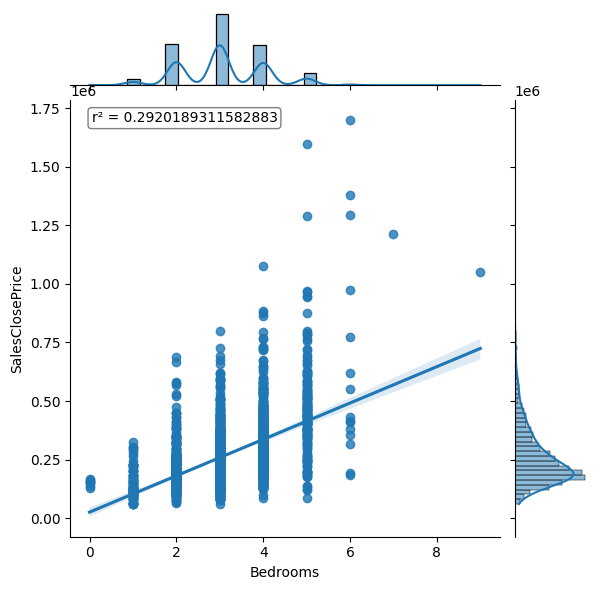

In [14]:
# Sample and create pandas dataframe
pandas_df = df.sample(False, 0.5, 0).toPandas()

# Linear model plots - Total_SQFT
linear_model_plot(x='Bedrooms', y='SalesClosePrice', df=pandas_df)
plt.show()

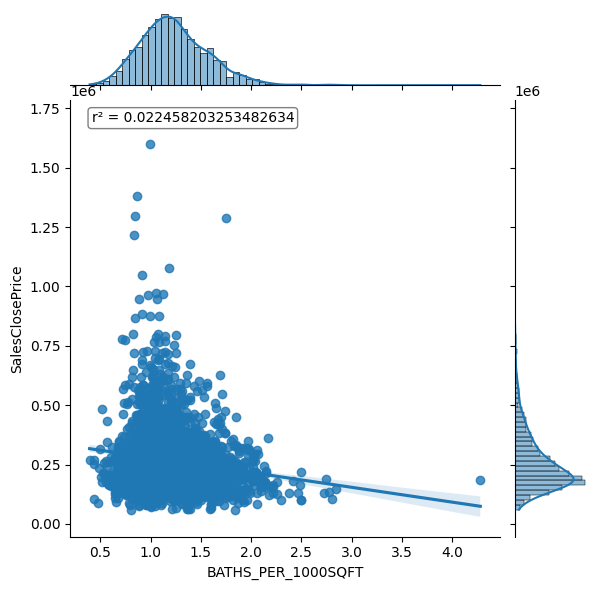

In [15]:
# Linear model plots - BATHS_PER_1000SQFT
linear_model_plot(x='BATHS_PER_1000SQFT', y='SalesClosePrice', df=pandas_df)
plt.show()

## Time Features

### Treating Date Fields as Dates

In [16]:
# Initializing the data
df = real_state.select('*')
print('Dataframe shape:', (df.count(), len(df.columns)))
df.limit(2)

Dataframe shape: (5000, 74)


No.,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PoolDescription,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,UNITNUMBER,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,backonmarketdate,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,Class,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation
1,RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,NULL,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,NULL,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,SF,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,NULL,NULL,3,0,NULL,0,Unknown,0.0
2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,NULL,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,NULL,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",NULL,Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,SF,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,11x11,Lower,4,960,NULL,0,Unknown,0.0


In [17]:
# Inspect the field
print(df[['LISTDATE']].dtypes)
df[['LISTDATE']].show(2)

[('LISTDATE', 'string')]
+--------------+
|      LISTDATE|
+--------------+
|7/15/2017 0:00|
|10/9/2017 0:00|
+--------------+
only showing top 2 rows



In [18]:
# Cast the data type to Date
df = df.withColumn('LISTDATE', F.to_date('LISTDATE', format='M/d/yyyy H:m'))

# Inspecting results
print(df[['LISTDATE']].dtypes)
df[['LISTDATE']].show(2)

[('LISTDATE', 'date')]
+----------+
|  LISTDATE|
+----------+
|2017-07-15|
|2017-10-09|
+----------+
only showing top 2 rows



### Time Components

In [19]:
# Create a new column of year number
df = df.withColumn('LIST_YEAR', F.year('LISTDATE'))

# Create a new column of month number
df = df.withColumn('LIST_MONTH', F.month('LISTDATE'))

# Create new columns of the day number within the month
df = df.withColumn('LIST_DAYOFMONTH', F.dayofmonth('LISTDATE'))

# Create new columns of the week number within the year
df = df.withColumn('LIST_WEEKOFYEAR', F.weekofyear('LISTDATE'))

# Create new columns of the week number within the year
df = df.withColumn('DAY_NAME_ABR', F.date_format('LISTDATE', 'E'))

# Create new columns of the week number within the year
df = df.withColumn('DAY_NAME', F.date_format('LISTDATE', 'EEEE'))

# Inspecting results
column_list = ['LISTDATE', 'LIST_YEAR', 'LIST_MONTH', 'LIST_DAYOFMONTH', 'LIST_WEEKOFYEAR',
               'DAY_NAME_ABR', 'DAY_NAME']
pprint(df[column_list].dtypes)
df[column_list].show(2)

[('LISTDATE', 'date'),
 ('LIST_YEAR', 'int'),
 ('LIST_MONTH', 'int'),
 ('LIST_DAYOFMONTH', 'int'),
 ('LIST_WEEKOFYEAR', 'int'),
 ('DAY_NAME_ABR', 'string'),
 ('DAY_NAME', 'string')]
+----------+---------+----------+---------------+---------------+------------+--------+
|  LISTDATE|LIST_YEAR|LIST_MONTH|LIST_DAYOFMONTH|LIST_WEEKOFYEAR|DAY_NAME_ABR|DAY_NAME|
+----------+---------+----------+---------------+---------------+------------+--------+
|2017-07-15|     2017|         7|             15|             28|         Sat|Saturday|
|2017-10-09|     2017|        10|              9|             41|         Mon|  Monday|
+----------+---------+----------+---------------+---------------+------------+--------+
only showing top 2 rows



### Basic Time Based Metrics

In [20]:
# Calculate difference between two date fields
df.withColumn('DAYSONMARKET', F.datediff('OFFMARKETDATE', 'LISTDATE'))

# Inspecting results
column_list = ['DAYSONMARKET', 'OFFMARKETDATE', 'LISTDATE']
pprint(df[column_list].dtypes)
df[column_list].show(2)

[('DAYSONMARKET', 'int'), ('OFFMARKETDATE', 'timestamp'), ('LISTDATE', 'date')]
+------------+-------------------+----------+
|DAYSONMARKET|      OFFMARKETDATE|  LISTDATE|
+------------+-------------------+----------+
|          10|2017-07-30 00:00:00|2017-07-15|
|           4|2017-10-13 00:00:00|2017-10-09|
+------------+-------------------+----------+
only showing top 2 rows



### Lagging Features

In [21]:
# Create Window
w = Window().orderBy(df['LISTDATE'])

# Create lagged column
df = df.withColumn('LISTPRICE-WK', F.lag('LISTPRICE', offset=2).over(w))

# Inspect results
column_list = ['LISTDATE', 'LISTPRICE-WK', 'LISTPRICE']
pprint(df[column_list].dtypes)
df[column_list].show(5)

[('LISTDATE', 'date'), ('LISTPRICE-WK', 'int'), ('LISTPRICE', 'int')]
+----------+------------+---------+
|  LISTDATE|LISTPRICE-WK|LISTPRICE|
+----------+------------+---------+
|2017-02-23|        NULL|   194000|
|2017-02-24|        NULL|   189900|
|2017-02-24|      194000|   206900|
|2017-02-24|      189900|   239900|
|2017-02-24|      206900|   139900|
+----------+------------+---------+
only showing top 5 rows



## Ex. 4 - Time Components

Being able to work with time components for building features is important but you can also use them to explore and understand your data further. In this exercise, you'll be looking to see if there is a pattern to which day of the week a house lists on. Please keep in mind that PySpark's week starts on Sunday, with a value of 1 and ends on Saturday, a value of 7.

**Instructions:**

1. Import `to_date()` and `dayofweek()` functions from `pyspark.sql.functions` (Already done.)
2. Use the `to_date()` function to convert `LISTDATE` to a Spark `date` type, save the converted column in place using `withColumn()`
3. Create a new column using `LISTDATE` and `dayofweek()` then save it as `List_Day_of_Week` using `withColumn()`
4. Sample half the dataframe and convert it to a pandas dataframe with `toPandas()` and plot the count of the pandas dataframe's `List_Day_of_Week` column by using seaborn `countplot()` where `x = List_Day_of_Week`.

In [22]:
# Initializing the data
df = real_state.select('*')
print('Dataframe shape:', (df.count(), len(df.columns)))
df.limit(2)

Dataframe shape: (5000, 74)


No.,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PoolDescription,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,UNITNUMBER,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,backonmarketdate,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,Class,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation
1,RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,NULL,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,NULL,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,SF,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,NULL,NULL,3,0,NULL,0,Unknown,0.0
2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,NULL,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,NULL,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",NULL,Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,SF,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,11x11,Lower,4,960,NULL,0,Unknown,0.0


In [23]:
# Convert to date type
if df[['LISTDATE']].dtypes[0][1] == 'string':
    df = df.withColumn('LISTDATE', F.to_date('LISTDATE', format='M/d/yyyy H:m'))

# Get the day of the week
df = df.withColumn('List_Day_of_Week', F.dayofweek('LISTDATE'))

# Inspect the result
column_list = ['LISTDATE', 'List_Day_of_Week']
pprint(df[column_list].dtypes)
df[column_list].show(2)

[('LISTDATE', 'date'), ('List_Day_of_Week', 'int')]
+----------+----------------+
|  LISTDATE|List_Day_of_Week|
+----------+----------------+
|2017-07-15|               7|
|2017-10-09|               2|
+----------+----------------+
only showing top 2 rows



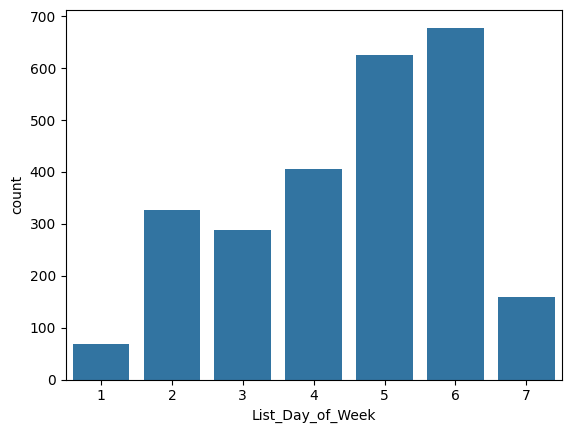

In [24]:
# Sample and convert to pandas dataframe
sample_df = df.sample(False, .5, 42).toPandas()

# Plot count plot of of day of week
sns.countplot(x="List_Day_of_Week", data=sample_df)
plt.show()

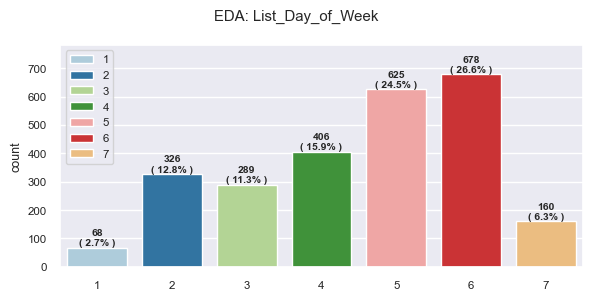

In [25]:
# Using the custom function
labeled_barplot(sample_df["List_Day_of_Week"], order=False)
plt.legend(loc='upper left')
plt.show()

## Ex. 5 - Joining On Time 

Often times you will use date components to join in other sets of information. However, in this example, we need to use data that would have been available to those considering buying a house. This means we will need to use the previous year's reporting data for our analysis.

**Instructions:**

1. Extract the year from `LISTDATE` using `year()` and put it into a new column called `list_year` with `withColumn()`
2. Create another new column called `report_year` by subtracting `1` from the `list_year`
3. Create a join condition that matches `df['CITY']` with `price_df['City']` and `df['report_year']` with `price_df['Year']`
4. Perform a left join between `df` and `price_df`

In [26]:
# Loading a new table
price_df = spark.read.csv('data-sources/real-state-medianprices.csv', header=True, inferSchema=True)
print('Dataframe shape:', (price_df.count(), len(price_df.columns)))
price_df.printSchema()
price_df

Dataframe shape: (10, 3)
root
 |-- MedianCity: string (nullable = true)
 |-- MedianHomeValue: integer (nullable = true)
 |-- MedianYear: integer (nullable = true)



MedianCity,MedianHomeValue,MedianYear
LELM - Lake Elmo,401000,2016
MAPW - Maplewood,193000,2016
STP - Saint Paul,172000,2016
WB - Woodbury,291000,2016
OAKD - Oakdale,210000,2016
LELM - Lake Elmo,385000,2015
MAPW - Maplewood,187000,2015
STP - Saint Paul,162000,2015
WB - Woodbury,277000,2015
OAKD - Oakdale,192000,2015


In [27]:
# Create year column
df = df.withColumn('list_year', F.year('LISTDATE'))

# Adjust year to match
df = df.withColumn('report_year', (df['list_year'] - 1))

# Inspect the result
column_list = ['CITY', 'list_year', 'report_year']
pprint(df[column_list].dtypes)
df[column_list].show(2)

[('CITY', 'string'), ('list_year', 'int'), ('report_year', 'int')]
+----------------+---------+-----------+
|            CITY|list_year|report_year|
+----------------+---------+-----------+
|LELM - Lake Elmo|     2017|       2016|
|LELM - Lake Elmo|     2017|       2016|
+----------------+---------+-----------+
only showing top 2 rows



In [28]:
# Create join condition
condition = [df['CITY'] == price_df['MedianCity'], df['report_year'] == price_df['MedianYear']]

# Join the dataframes together
df = df.join(price_df, on=condition, how='left')

# Inspect that new columns are available
column_list = ['CITY', 'list_year', 'report_year', 'MedianHomeValue']
pprint(df[column_list].dtypes)
df[column_list].show(2)

[('CITY', 'string'),
 ('list_year', 'int'),
 ('report_year', 'int'),
 ('MedianHomeValue', 'int')]
+----------------+---------+-----------+---------------+
|            CITY|list_year|report_year|MedianHomeValue|
+----------------+---------+-----------+---------------+
|LELM - Lake Elmo|     2017|       2016|         401000|
|LELM - Lake Elmo|     2017|       2016|         401000|
+----------------+---------+-----------+---------------+
only showing top 2 rows



## Ex. 6 - Date Math

In this example, we'll look at verifying the frequency of our data. The Mortgage dataset is supposed to have weekly data but let's make sure by lagging the report date and then taking the difference of the dates.

Recall that to create a lagged feature we will need to create a `Window()`. `Window()` allows you to return a value for each record based off some calculation against a group of records, in this case, the previous period's mortgage rate.

**Instructions:**

1. Cast `mort_df['DATE']` to `date` type with `to_date()`
2. Create a window with the `Window()` function and use `orderBy()` to sort by `mort_df[DATE]`
3. Create a new column `DATE-1` using `withColumn()` by lagging the `DATE` column with `lag()` and window it using `over(w)`
4. Calculate the difference between `DATE` and `DATE-1` using `datediff()` and name it `Days_Between_Report`

In [29]:
# Loading the data
mort_df = spark.read.csv('data-sources/mortage-data.csv', header=True, inferSchema=True)
print('Dataframe shape:', (mort_df.count(), len(mort_df.columns)))
mort_df.printSchema()
mort_df.show(2)

Dataframe shape: (261, 2)
root
 |-- DATE: string (nullable = true)
 |-- MORTGAGE30US: double (nullable = true)

+----------+------------+
|      DATE|MORTGAGE30US|
+----------+------------+
|10/10/2013|        4.23|
|10/17/2013|        4.28|
+----------+------------+
only showing top 2 rows



In [30]:
# Cast data type
mort_df = mort_df.withColumn('DATE', F.to_date('DATE', format='M/d/yyyy'))

# Create window
w = Window().orderBy(mort_df['DATE'])

# Create lag column
mort_df = mort_df.withColumn('DATE-1', F.lag('DATE', offset=1).over(w))

# Calculate difference between date columns
mort_df = mort_df.withColumn('Days_Between_Report', F.datediff('DATE', 'DATE-1'))

# Inspect the result
column_list = ['DATE', 'DATE-1', 'Days_Between_Report']
pprint(mort_df[column_list].dtypes)
mort_df[column_list].show(5)

[('DATE', 'date'), ('DATE-1', 'date'), ('Days_Between_Report', 'int')]
+----------+----------+-------------------+
|      DATE|    DATE-1|Days_Between_Report|
+----------+----------+-------------------+
|2013-10-10|      NULL|               NULL|
|2013-10-17|2013-10-10|                  7|
|2013-10-24|2013-10-17|                  7|
|2013-10-31|2013-10-24|                  7|
|2013-11-07|2013-10-31|                  7|
+----------+----------+-------------------+
only showing top 5 rows



In [31]:
mort_df.groupby('Days_Between_Report').count()

Days_Between_Report,count
7,248
6,6
8,6
NULL,1


## Extracting Features

In [32]:
# Loading the data.
roof_df = spark.createDataFrame([
    (1, "Asphalt Shingles, Pitched, Age 8 Years or Less"),
    (2, None),
    (3, "Asphalt Shingles, Age Over 8 Years"),
    (4, "Asphalt Shingles, Age 8 Years or Less"),
    (5, "Asphalt Shingles"),
    (6, "Metal, Age Over 8 Years"),
    (7, "Tile, Age 8 Years or Less"),
    (8, "Asphalt Shingles")
], schema='ID int, ROOF string')
print('Dataframe shape:', (roof_df.count(), len(roof_df.columns)))
roof_df.printSchema()
roof_df.show()

Dataframe shape: (8, 2)
root
 |-- ID: integer (nullable = true)
 |-- ROOF: string (nullable = true)

+---+--------------------+
| ID|                ROOF|
+---+--------------------+
|  1|Asphalt Shingles,...|
|  2|                NULL|
|  3|Asphalt Shingles,...|
|  4|Asphalt Shingles,...|
|  5|    Asphalt Shingles|
|  6|Metal, Age Over 8...|
|  7|Tile, Age 8 Years...|
|  8|    Asphalt Shingles|
+---+--------------------+



### Extracting Age with Text Match

In [33]:
# Create boolean filters
find_under_8 = roof_df['ROOF'].like('%Age 8 Years or Less%')
find_over_8 = roof_df['ROOF'].like('%Age Over 8 Years%')

# Apply filters using when() and otherwise()
roof_df = roof_df.withColumn('Roof>8yrs', 
                             F.when(find_over_8, 1).when(find_under_8, 0).otherwise(None))
# Inspect results
roof_df.show(truncate=100)

+---+----------------------------------------------+---------+
| ID|                                          ROOF|Roof>8yrs|
+---+----------------------------------------------+---------+
|  1|Asphalt Shingles, Pitched, Age 8 Years or Less|        0|
|  2|                                          NULL|     NULL|
|  3|            Asphalt Shingles, Age Over 8 Years|        1|
|  4|         Asphalt Shingles, Age 8 Years or Less|        0|
|  5|                              Asphalt Shingles|     NULL|
|  6|                       Metal, Age Over 8 Years|        1|
|  7|                     Tile, Age 8 Years or Less|        0|
|  8|                              Asphalt Shingles|     NULL|
+---+----------------------------------------------+---------+



### Splitting Columns

In [34]:
# Split the column on commas into a list
split_col = F.split(roof_df['ROOF'], ',')

# Put the first value of the list into a new column
roof_df = roof_df.withColumn('Roof_Material', split_col.getItem(0))

# Inspect results
roof_df.show(truncate=100)

+---+----------------------------------------------+---------+----------------+
| ID|                                          ROOF|Roof>8yrs|   Roof_Material|
+---+----------------------------------------------+---------+----------------+
|  1|Asphalt Shingles, Pitched, Age 8 Years or Less|        0|Asphalt Shingles|
|  2|                                          NULL|     NULL|            NULL|
|  3|            Asphalt Shingles, Age Over 8 Years|        1|Asphalt Shingles|
|  4|         Asphalt Shingles, Age 8 Years or Less|        0|Asphalt Shingles|
|  5|                              Asphalt Shingles|     NULL|Asphalt Shingles|
|  6|                       Metal, Age Over 8 Years|        1|           Metal|
|  7|                     Tile, Age 8 Years or Less|        0|            Tile|
|  8|                              Asphalt Shingles|     NULL|Asphalt Shingles|
+---+----------------------------------------------+---------+----------------+



### Explode & Pivot

In [35]:
# Split the column on commas into a list
roof_df = roof_df.withColumn('roof_list', F.split(roof_df['ROOF'], ', '))
roof_df.show(truncate=40)

+---+----------------------------------------+---------+----------------+----------------------------------------+
| ID|                                    ROOF|Roof>8yrs|   Roof_Material|                               roof_list|
+---+----------------------------------------+---------+----------------+----------------------------------------+
|  1|Asphalt Shingles, Pitched, Age 8 Year...|        0|Asphalt Shingles|[Asphalt Shingles, Pitched, Age 8 Yea...|
|  2|                                    NULL|     NULL|            NULL|                                    NULL|
|  3|      Asphalt Shingles, Age Over 8 Years|        1|Asphalt Shingles|    [Asphalt Shingles, Age Over 8 Years]|
|  4|   Asphalt Shingles, Age 8 Years or Less|        0|Asphalt Shingles| [Asphalt Shingles, Age 8 Years or Less]|
|  5|                        Asphalt Shingles|     NULL|Asphalt Shingles|                      [Asphalt Shingles]|
|  6|                 Metal, Age Over 8 Years|        1|           Metal|       

In [36]:
# Explode list into new records for each value
ex_df = roof_df.withColumn('ex_roof_list', F.explode(roof_df['roof_list']))
ex_df.select('ID', 'ROOF', 'roof_list', 'ex_roof_list').show(truncate=40)

+---+----------------------------------------+----------------------------------------+-------------------+
| ID|                                    ROOF|                               roof_list|       ex_roof_list|
+---+----------------------------------------+----------------------------------------+-------------------+
|  1|Asphalt Shingles, Pitched, Age 8 Year...|[Asphalt Shingles, Pitched, Age 8 Yea...|   Asphalt Shingles|
|  1|Asphalt Shingles, Pitched, Age 8 Year...|[Asphalt Shingles, Pitched, Age 8 Yea...|            Pitched|
|  1|Asphalt Shingles, Pitched, Age 8 Year...|[Asphalt Shingles, Pitched, Age 8 Yea...|Age 8 Years or Less|
|  3|      Asphalt Shingles, Age Over 8 Years|    [Asphalt Shingles, Age Over 8 Years]|   Asphalt Shingles|
|  3|      Asphalt Shingles, Age Over 8 Years|    [Asphalt Shingles, Age Over 8 Years]|   Age Over 8 Years|
|  4|   Asphalt Shingles, Age 8 Years or Less| [Asphalt Shingles, Age 8 Years or Less]|   Asphalt Shingles|
|  4|   Asphalt Shingles, Ag

In [37]:
# Not loosing Nulls
(
    roof_df.withColumn('ex_roof_list', F.explode_outer(roof_df['roof_list']))
           .select('ID', 'ROOF', 'roof_list', 'ex_roof_list')
           .show(truncate=40)
)

+---+----------------------------------------+----------------------------------------+-------------------+
| ID|                                    ROOF|                               roof_list|       ex_roof_list|
+---+----------------------------------------+----------------------------------------+-------------------+
|  1|Asphalt Shingles, Pitched, Age 8 Year...|[Asphalt Shingles, Pitched, Age 8 Yea...|   Asphalt Shingles|
|  1|Asphalt Shingles, Pitched, Age 8 Year...|[Asphalt Shingles, Pitched, Age 8 Yea...|            Pitched|
|  1|Asphalt Shingles, Pitched, Age 8 Year...|[Asphalt Shingles, Pitched, Age 8 Yea...|Age 8 Years or Less|
|  2|                                    NULL|                                    NULL|               NULL|
|  3|      Asphalt Shingles, Age Over 8 Years|    [Asphalt Shingles, Age Over 8 Years]|   Asphalt Shingles|
|  3|      Asphalt Shingles, Age Over 8 Years|    [Asphalt Shingles, Age Over 8 Years]|   Age Over 8 Years|
|  4|   Asphalt Shingles, Ag

In [38]:
# Create a dummy column of constant value
ex_df = ex_df.withColumn('constant_val', F.lit(1))

# Pivot the values into boolean columns
piv_df = ex_df.groupBy(['ID', 'ROOF', 'roof_list']).pivot('ex_roof_list').agg(F.coalesce(F.first('constant_val')))

# Inspect the result
print('Dataframe shape:', (piv_df.count(), len(piv_df.columns)))
piv_df.printSchema()
piv_df

Dataframe shape: (7, 9)
root
 |-- ID: integer (nullable = true)
 |-- ROOF: string (nullable = true)
 |-- roof_list: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- Age 8 Years or Less: integer (nullable = true)
 |-- Age Over 8 Years: integer (nullable = true)
 |-- Asphalt Shingles: integer (nullable = true)
 |-- Metal: integer (nullable = true)
 |-- Pitched: integer (nullable = true)
 |-- Tile: integer (nullable = true)



ID,ROOF,roof_list,Age 8 Years or Less,Age Over 8 Years,Asphalt Shingles,Metal,Pitched,Tile
1,"Asphalt Shingles,...",[Asphalt Shingles...,1,NULL,1,NULL,1,NULL
8,Asphalt Shingles,[Asphalt Shingles],NULL,NULL,1,NULL,NULL,NULL
7,"Tile, Age 8 Years...","[Tile, Age 8 Year...",1,NULL,NULL,NULL,NULL,1
5,Asphalt Shingles,[Asphalt Shingles],NULL,NULL,1,NULL,NULL,NULL
4,"Asphalt Shingles,...",[Asphalt Shingles...,1,NULL,1,NULL,NULL,NULL
6,"Metal, Age Over 8...","[Metal, Age Over ...",NULL,1,NULL,1,NULL,NULL
3,"Asphalt Shingles,...",[Asphalt Shingles...,NULL,1,1,NULL,NULL,NULL


## Ex. 7 - Extracting Text to New Features

Garages are an important consideration for houses in Minnesota where most people own a car and the snow is annoying to clear off a car parked outside. The type of garage is also important, can you get to your car without braving the cold or not? Let's look at creating a feature `has_attached_garage` that captures whether the garage is attached to the house or not.

**Instructions:**

1. Import the needed function `when()` from `pyspark.sql.functions`. (Already Done)
2. Create a string matching condition using `like()` to look for for the string pattern Attached Garage in `df['GARAGEDESCRIPTION']` and use wildcards `%` so it will match anywhere in the field.
3. Similarly, create another condition using `like()` to find the string pattern Detached Garage in `df['GARAGEDESCRIPTION']` and use wildcards `%` so it will match anywhere in the field.
4. Create a new column `has_attached_garage` using `when()` to assign the value `1` if it has an attached garage, zero if detached and use `otherwise()` to assign null with `None` if it is neither.

In [39]:
# Initializing the data
df = real_state.select('*')
print('Dataframe shape:', (df.count(), len(df.columns)))
df.select('GARAGEDESCRIPTION').show(10, truncate=False)

Dataframe shape: (5000, 74)
+--------------------------------------------------------------+
|GARAGEDESCRIPTION                                             |
+--------------------------------------------------------------+
|Attached Garage                                               |
|Attached Garage, Driveway - Asphalt, Garage Door Opener       |
|Attached Garage                                               |
|Attached Garage, Detached Garage, Tuckunder, Driveway - Gravel|
|Attached Garage, Driveway - Asphalt, Garage Door Opener       |
|Attached Garage, Driveway - Asphalt                           |
|Attached Garage, Driveway - Asphalt, Garage Door Opener       |
|Attached Garage                                               |
|Attached Garage                                               |
|Attached Garage                                               |
+--------------------------------------------------------------+
only showing top 10 rows



In [40]:
# Create boolean conditions for string matches
has_attached_garage = df['GARAGEDESCRIPTION'].like("%Attached Garage%")
has_detached_garage = df['GARAGEDESCRIPTION'].like("%Detached Garage%")

# Conditional value assignment 
df = df.withColumn('has_attached_garage', (F.when(has_attached_garage, 1)
                                            .when(has_detached_garage, 0)
                                            .otherwise(None)))

# Inspect results
df[['GARAGEDESCRIPTION', 'has_attached_garage']].show(10, truncate=100)

+--------------------------------------------------------------+-------------------+
|                                             GARAGEDESCRIPTION|has_attached_garage|
+--------------------------------------------------------------+-------------------+
|                                               Attached Garage|                  1|
|       Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                                               Attached Garage|                  1|
|Attached Garage, Detached Garage, Tuckunder, Driveway - Gravel|                  1|
|       Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                           Attached Garage, Driveway - Asphalt|                  1|
|       Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                                               Attached Garage|                  1|
|                                               Attached Garage| 

## Ex. 8 - Splitting & Exploding

Being able to take a compound field like `GARAGEDESCRIPTION` and massaging it into something useful is an involved process. It's helpful to understand early what value you might gain out of expanding it. In this example, we will convert our string to a list-like array, explode it and then inspect the unique values.

**Instructions:**

1. Import the needed functions `split()` and `explode()` from `pyspark.sql.functions` (Already done)
2. Use `split()` to create a new column `garage_list` by splitting `df['GARAGEDESCRIPTION']` on `', '` which is both a comma and a space.
3. Create a new record for each value in the `df['garage_list']` using `explode()` and assign it a new column `ex_garage_list`
4. Use `distinct()` to get unique values of `ex_garage_list` and show the result, truncating them at `50` characters to display the values.

In [41]:
# Convert string to list-like array
df = df.withColumn('garage_list', F.split(df['GARAGEDESCRIPTION'], ', '))

# Explode the values into new records
ex_df = df.withColumn('ex_garage_list', F.explode(df['garage_list']))

# Inspect result
ex_df[['`No.`','GARAGEDESCRIPTION', 'garage_list', 'ex_garage_list']].show(10, truncate=40)

+---+----------------------------------------+----------------------------------------+------------------+
|No.|                       GARAGEDESCRIPTION|                             garage_list|    ex_garage_list|
+---+----------------------------------------+----------------------------------------+------------------+
|  1|                         Attached Garage|                       [Attached Garage]|   Attached Garage|
|  2|Attached Garage, Driveway - Asphalt, ...|[Attached Garage, Driveway - Asphalt,...|   Attached Garage|
|  2|Attached Garage, Driveway - Asphalt, ...|[Attached Garage, Driveway - Asphalt,...|Driveway - Asphalt|
|  2|Attached Garage, Driveway - Asphalt, ...|[Attached Garage, Driveway - Asphalt,...|Garage Door Opener|
|  3|                         Attached Garage|                       [Attached Garage]|   Attached Garage|
|  4|Attached Garage, Detached Garage, Tuc...|[Attached Garage, Detached Garage, Tu...|   Attached Garage|
|  4|Attached Garage, Detached Garage

In [42]:
# Show unique values of `ex_garage_list`.
print('Total rows:', ex_df[['ex_garage_list']].distinct().count())
ex_df[['ex_garage_list']].distinct().show(truncate=50)

Total rows: 28
+----------------------------+
|              ex_garage_list|
+----------------------------+
|             Attached Garage|
|      On-Street Parking Only|
|                        None|
| More Parking Onsite for Fee|
|          Garage Door Opener|
|   No Int Access to Dwelling|
|           Driveway - Gravel|
|       Valet Parking for Fee|
|              Uncovered/Open|
|               Heated Garage|
|          Underground Garage|
|                       Other|
|                  Unassigned|
|More Parking Offsite for Fee|
|    Driveway - Other Surface|
|       Contract Pkg Required|
|                     Carport|
|                     Secured|
|             Detached Garage|
|          Driveway - Asphalt|
+----------------------------+
only showing top 20 rows



In [43]:
# Show unique values of `ex_garage_list`.
print('Total rows:', ex_df.groupby('ex_garage_list').count().count())
ex_df.groupby('ex_garage_list').count().show(truncate=50)

Total rows: 28
+----------------------------+-----+
|              ex_garage_list|count|
+----------------------------+-----+
|             Attached Garage| 2262|
|      On-Street Parking Only|   35|
|                        None|   62|
| More Parking Onsite for Fee|   40|
|          Garage Door Opener| 2129|
|   No Int Access to Dwelling|   54|
|           Driveway - Gravel|   65|
|       Valet Parking for Fee|    8|
|              Uncovered/Open|   99|
|               Heated Garage|  289|
|          Underground Garage|  160|
|                       Other|   94|
|                  Unassigned|   21|
|More Parking Offsite for Fee|   26|
|    Driveway - Other Surface|   51|
|       Contract Pkg Required|   20|
|                     Carport|   24|
|                     Secured|   79|
|             Detached Garage| 2198|
|          Driveway - Asphalt| 1513|
+----------------------------+-----+
only showing top 20 rows



## Ex. 9 - Pivot & Join

Being able to explode and pivot a compound field is great, but you are left with a dataframe of only those pivoted values. To really be valuable you'll need to rejoin it to the original dataset! After joining the datasets we will have a lot of NULL values for the newly created columns since we know the context of how they were created we can safely fill them in with zero as either the new has an attribute or it doesn't.

**Instructions:**

1. Pivot the values of `ex_garage_list` by grouping by the record id NO with `groupBy()` use the provided code to aggregate `constant_val` to ignore nulls and take the first value.
2. Left join `piv_df` to `df` using `No.` as the join condition.
3. Create the list of columns, `zfill_cols`, to zero fill by using the columns attribute on `piv_df`
4. Zero fill the pivoted dataframes columns, `zfill_cols`, by using `fillna()` with a subset.

In [44]:
# Reviewing the data
print('Dataframe shape:', (ex_df.count(), len(ex_df.columns)))
ex_df.select('`No.`', 'GARAGEDESCRIPTION', 'garage_list', 'ex_garage_list').show(5, truncate=40)

Dataframe shape: (11209, 77)
+---+----------------------------------------+----------------------------------------+------------------+
|No.|                       GARAGEDESCRIPTION|                             garage_list|    ex_garage_list|
+---+----------------------------------------+----------------------------------------+------------------+
|  1|                         Attached Garage|                       [Attached Garage]|   Attached Garage|
|  2|Attached Garage, Driveway - Asphalt, ...|[Attached Garage, Driveway - Asphalt,...|   Attached Garage|
|  2|Attached Garage, Driveway - Asphalt, ...|[Attached Garage, Driveway - Asphalt,...|Driveway - Asphalt|
|  2|Attached Garage, Driveway - Asphalt, ...|[Attached Garage, Driveway - Asphalt,...|Garage Door Opener|
|  3|                         Attached Garage|                       [Attached Garage]|   Attached Garage|
+---+----------------------------------------+----------------------------------------+------------------+
only sho

In [45]:
# Create a dummy column of constant value
ex_df = ex_df.withColumn('constant_val', F.lit(1))

# Pivot 
piv_df = ex_df.groupBy('`No.`').pivot('ex_garage_list').agg(F.coalesce(F.first('constant_val')))
print('Dataframe shape:', (piv_df.count(), len(piv_df.columns)))
piv_df.fillna(0).limit(3)

Dataframe shape: (5000, 29)


No.,Assigned,Attached Garage,Carport,Contract Pkg Required,Covered,Detached Garage,Driveway - Asphalt,Driveway - Concrete,Driveway - Gravel,Driveway - Other Surface,Driveway - Shared,Garage Door Opener,Heated Garage,Insulated Garage,More Parking Offsite for Fee,More Parking Onsite for Fee,No Int Access to Dwelling,None,On-Street Parking Only,Other,Secured,Tandem,Tuckunder,Unassigned,Uncovered/Open,Underground Garage,Units Vary,Valet Parking for Fee
3918,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4519,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1238,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
# Join the dataframes together
joined_df = df.join(piv_df, on='No.', how='left')
print('Dataframe shape:', (joined_df.count(), len(joined_df.columns)))
joined_df.limit(2)

Dataframe shape: (5000, 104)


No.,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,LISTPRICE,LISTTYPE,OriginalListPrice,PricePerTSFT,FOUNDATIONSIZE,FENCE,MapLetter,LotSizeDimensions,SchoolDistrictNumber,DAYSONMARKET,offmarketdate,Fireplaces,RoomArea4,roomtype,ROOF,RoomFloor4,PotentialShortSale,PoolDescription,PDOM,GarageDescription,SQFTABOVEGROUND,Taxes,RoomFloor1,RoomArea1,TAXWITHASSESSMENTS,TAXYEAR,LivingArea,UNITNUMBER,YEARBUILT,ZONING,STYLE,ACRES,CoolingDescription,APPLIANCES,backonmarketdate,ROOMFAMILYCHAR,RoomArea3,EXTERIOR,RoomFloor3,RoomFloor2,RoomArea2,DiningRoomDescription,BASEMENT,BathsFull,BathsHalf,BATHQUARTER,BATHSTHREEQUARTER,Class,BATHSTOTAL,BATHDESC,RoomArea5,RoomFloor5,RoomArea6,RoomFloor6,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation,has_attached_garage,garage_list,Assigned,Attached Garage,Carport,Contract Pkg Required,Covered,Detached Garage,Driveway - Asphalt,Driveway - Concrete,Driveway - Gravel,Driveway - Other Surface,Driveway - Shared,Garage Door Opener,Heated Garage,Insulated Garage,More Parking Offsite for Fee,More Parking Onsite for Fee,No Int Access to Dwelling,None,On-Street Parking Only,Other,Secured,Tandem,Tuckunder,Unassigned,Uncovered/Open,Underground Garage,Units Vary,Valet Parking for Fee
1,RMLS,11511,11511 Stillwater ...,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,139900,Exclusive Right,139900,145.9184,980,Other,C4,279X200,834 - Stillwater,10,2017-07-30 00:00:00,0,12 x 9,"Living Room, Dini...",NULL,Main,No,NULL,10,Attached Garage,980,1858,Main,16 x 13,1858.0,2017,980,NULL,1950,Residential-Single,(SF) One Story,1.28,Central,"Range, Dishwasher...",NULL,NULL,NULL,Vinyl,NULL,Main,9 x 7,Eat In Kitchen,Full,1,1,0,0,SF,2,Main Floor 3/4 Ba...,13 x 11,Main,10 x 10,Main,NULL,NULL,NULL,NULL,3,0,NULL,0,Unknown,0.0,1,[Attached Garage],NULL,1,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL
2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,210000,Exclusive Right,210000,85.2783,1144,NULL,C1,100x140,834 - Stillwater,4,2017-10-13 00:00:00,0,11x11,"Living Room, Dini...","Asphalt Shingles,...",Main,No,NULL,4,"Attached Garage, ...",1268,1640,Main,22x14,1640.0,2017,2228,NULL,1971,Residential-Single,(SF) Split Entry ...,0.32,Central,"Range, Microwave,...",NULL,Lower Level,22x14,Vinyl,Lower,Main,11x12,Informal Dining R...,"Full, Partial Fin...",1,0,0,2,SF,3,Main Floor Full B...,15x11,Main,14x11,Main,10x11,Main,11x11,Lower,4,960,NULL,0,Unknown,0.0,1,"[Attached Garage,...",NULL,1,NULL,NULL,NULL,NULL,1,NULL,NULL,NULL,NULL,1,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL


In [47]:
# Columns to zero fill
zfill_cols = piv_df.columns[1:]

# Zero fill the pivoted values
zfilled_df = joined_df.fillna(0, subset=zfill_cols)
print('Dataframe shape:', (zfilled_df.count(), len(zfilled_df.columns)))
zfilled_df.select(zfill_cols).limit(2)

Dataframe shape: (5000, 104)


Assigned,Attached Garage,Carport,Contract Pkg Required,Covered,Detached Garage,Driveway - Asphalt,Driveway - Concrete,Driveway - Gravel,Driveway - Other Surface,Driveway - Shared,Garage Door Opener,Heated Garage,Insulated Garage,More Parking Offsite for Fee,More Parking Onsite for Fee,No Int Access to Dwelling,None,On-Street Parking Only,Other,Secured,Tandem,Tuckunder,Unassigned,Uncovered/Open,Underground Garage,Units Vary,Valet Parking for Fee
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Binarizing, Bucketing & Encoding

In [48]:
# Initializing the data
df = real_state.select('*')
print('Dataframe shape:', (df.count(), len(df.columns)))
column_list = ['Fireplaces', 'City', 'BATHSTOTAL']
pprint(df[column_list].dtypes)
df[column_list].distinct().show(40, truncate=False)

Dataframe shape: (5000, 74)
[('Fireplaces', 'int'), ('City', 'string'), ('BATHSTOTAL', 'int')]
+----------+----------------+----------+
|Fireplaces|City            |BATHSTOTAL|
+----------+----------------+----------+
|2         |OAKD - Oakdale  |4         |
|2         |MAPW - Maplewood|3         |
|0         |OAKD - Oakdale  |1         |
|2         |OAKD - Oakdale  |1         |
|2         |LELM - Lake Elmo|4         |
|1         |LELM - Lake Elmo|2         |
|1         |WB - Woodbury   |5         |
|1         |STP - Saint Paul|4         |
|0         |LELM - Lake Elmo|2         |
|8         |STP - Saint Paul|6         |
|2         |OAKD - Oakdale  |2         |
|3         |STP - Saint Paul|3         |
|2         |WB - Woodbury   |6         |
|1         |STP - Saint Paul|2         |
|0         |OAKD - Oakdale  |5         |
|1         |STP - Saint Paul|5         |
|0         |LELM - Lake Elmo|1         |
|0         |LELM - Lake Elmo|3         |
|1         |OAKD - Oakdale  |4         |
|0 

### Binarizing

In [49]:
# Cast the data type to double - required for binarization
df = df.withColumn('Fireplaces', df['Fireplaces'].cast('double'))

# Create binarizing transformer
bin = Binarizer(threshold=0.0, inputCol='Fireplaces', outputCol='FireplaceT')

# Apply the transformer
df_bin = bin.transform(df)

# Inspect the results
df_bin[['Fireplaces','FireplaceT']].distinct().show()

+----------+----------+
|Fireplaces|FireplaceT|
+----------+----------+
|       6.0|       1.0|
|       5.0|       1.0|
|       1.0|       1.0|
|       7.0|       1.0|
|       3.0|       1.0|
|       8.0|       1.0|
|       2.0|       1.0|
|       0.0|       0.0|
|       4.0|       1.0|
+----------+----------+



### Bucketing

In [50]:
# Define how to split data
catego_splits = [0, 1, 2, 3, 4, float('Inf')]

# Create bucketing transformer
buck = Bucketizer(splits=catego_splits, inputCol='BATHSTOTAL', outputCol='baths')

# Apply transformer
df_buck = buck.transform(df)

# Inspect results
df_buck[['BATHSTOTAL', 'baths']].distinct().show()

+----------+-----+
|BATHSTOTAL|baths|
+----------+-----+
|         6|  4.0|
|         5|  4.0|
|         4|  4.0|
|         3|  3.0|
|         2|  2.0|
|         1|  1.0|
|         7|  4.0|
+----------+-----+



### One Hot Encoding

In [51]:
# Create and fit the indexer transformer
stringIndexer = StringIndexer(inputCol="City", outputCol="City_Index").fit(df)

# Apply transformer
df_indexed = stringIndexer.transform(df)

# Inspect the results
df_indexed[['City', 'City_Index']].distinct().show()

+----------------+----------+
|            City|City_Index|
+----------------+----------+
|MAPW - Maplewood|       2.0|
|  OAKD - Oakdale|       3.0|
|LELM - Lake Elmo|       4.0|
|   WB - Woodbury|       1.0|
|STP - Saint Paul|       0.0|
+----------------+----------+



In [52]:
# Create encoder transformer
encoder = OneHotEncoder(inputCol='City_Index', outputCol='City_Vec').fit(df_indexed)
                        
# Apply the encoder transformer
encoded_df = encoder.transform(df_indexed)

# Inspect results
encoded_df[['City', 'City_Index', 'City_Vec']].distinct().show(10)

+----------------+----------+-------------+
|            City|City_Index|     City_Vec|
+----------------+----------+-------------+
|MAPW - Maplewood|       2.0|(4,[2],[1.0])|
|  OAKD - Oakdale|       3.0|(4,[3],[1.0])|
|   WB - Woodbury|       1.0|(4,[1],[1.0])|
|STP - Saint Paul|       0.0|(4,[0],[1.0])|
|LELM - Lake Elmo|       4.0|    (4,[],[])|
+----------------+----------+-------------+



## Ex. 10 - Binarizing Day of Week

In a previous video, we saw that it was very unlikely for a home to list on the weekend. Let's create a new field that says if the house is listed for sale on a weekday or not. In this example there is a field called `List_Day_of_Week` that has `Monday` is labeled `1.0` and `Sunday` is `7.0`. Let's convert this to a binary field with weekday being `0` and weekend being `1`. We can use the pyspark feature transformer `Binarizer` to do this.

**Instructions:**

1. Import the feature transformer `Binarizer` from `pyspark` and the `ml.feature` module.
2. Create the transformer using `Binarizer()` with the threshold for setting the value to `1` as anything after Friday, `5.0`, then set the input column as `List_Day_of_Week` and output column as `Listed_On_Weekend`.
3. Apply the binarizer transformation on `df` using `transform()`.
4. Verify the transformation worked correctly by selecting the `List_Day_of_Week` and `Listed_On_Weekend` columns with `show()`.

In [53]:
# Initializing the data
df = real_state.select('*')
df = df.withColumn('LISTDATE', F.to_date('LISTDATE', format='M/d/yyyy H:m'))
df = df.withColumn('List_Day_of_Week', F.dayofweek('LISTDATE'))
print('Dataframe shape:', (df.count(), len(df.columns)))
column_list = ['LISTDATE', 'List_Day_of_Week']
pprint(df[column_list].dtypes)
df[column_list].distinct().show(10, truncate=False)

Dataframe shape: (5000, 75)
[('LISTDATE', 'date'), ('List_Day_of_Week', 'int')]
+----------+----------------+
|LISTDATE  |List_Day_of_Week|
+----------+----------------+
|2017-06-12|2               |
|2017-10-09|2               |
|2017-10-24|3               |
|2017-10-14|7               |
|2017-05-26|6               |
|2017-10-10|3               |
|2017-04-11|3               |
|2017-11-25|7               |
|2017-03-29|4               |
|2017-07-19|4               |
+----------+----------------+
only showing top 10 rows



In [54]:
# Cast the data type to double - required for binarization
df = df.withColumn('List_Day_of_Week', df['List_Day_of_Week'].cast('double'))

# Create binarizing transformer
bin = Binarizer(threshold=5.0, inputCol='List_Day_of_Week', outputCol='Listed_On_Weekend')

# Apply the transformer
df_bin = bin.transform(df)

# Inspect the results
df_bin[['List_Day_of_Week','Listed_On_Weekend']].distinct().show()

+----------------+-----------------+
|List_Day_of_Week|Listed_On_Weekend|
+----------------+-----------------+
|             2.0|              0.0|
|             6.0|              1.0|
|             7.0|              1.0|
|             1.0|              0.0|
|             4.0|              0.0|
|             3.0|              0.0|
|             5.0|              0.0|
+----------------+-----------------+



## Ex. 11 - Bucketing
If you are a homeowner its very important if a house has 1, 2, 3 or 4 bedrooms. But like bathrooms, once you hit a certain point you don't really care whether the house has 7 or 8. This example we'll look at how to figure out where are some good value points to bucket.

**Instructions:**

1. Plot a distribution plot of the pandas dataframe `sample_df` using Seaborn `distplot()`.
2. Given it looks like there is a long tail of infrequent values after `5`, create the bucket splits of `1, 2, 3, 4, 5+`
3. Create the transformer `buck` by instantiating `Bucketizer()` with the splits for setting the buckets, then set the input column as `BEDROOMS` and output column as `bedrooms`.
4. Apply the Bucketizer transformation on `df` using `transform()` and assign the result to `df_bucket`. Then verify the results with `show()`

In [55]:
# Reviewing the data
df = real_state.select('*')
column_list = ['Bedrooms']
pprint(df[column_list].dtypes)
df[column_list].distinct().show(truncate=False)

[('Bedrooms', 'int')]
+--------+
|Bedrooms|
+--------+
|1       |
|6       |
|3       |
|5       |
|9       |
|4       |
|8       |
|7       |
|2       |
|0       |
+--------+



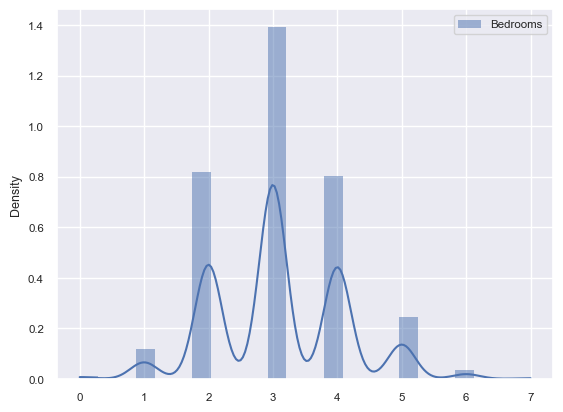

In [56]:
# Sample and create pandas dataframe
pandas_df = df.select(['Bedrooms']).sample(withReplacement=False, fraction=0.5, seed=42).toPandas()

# Plot distribution of sample_df
_ = sns.histplot(pandas_df, kde=True, stat="density", linewidth=0)
plt.show()

In [57]:
# Create the bucket splits and bucketizer
splits = [0, 1, 2, 3, 4, 5, float('Inf')]
buck = Bucketizer(splits=splits, inputCol='Bedrooms', outputCol='bedrooms_buck')

# Apply the transformation to df: df_bucket
df_bucket = buck.transform(df)

# Display results
df_bucket[['Bedrooms', 'bedrooms_buck']].distinct().orderBy('Bedrooms').show()

+--------+-------------+
|Bedrooms|bedrooms_buck|
+--------+-------------+
|       0|          0.0|
|       1|          1.0|
|       2|          2.0|
|       3|          3.0|
|       4|          4.0|
|       5|          5.0|
|       6|          5.0|
|       7|          5.0|
|       8|          5.0|
|       9|          5.0|
+--------+-------------+



## Ex. 12 - One Hot Encoding

In the United States where you live determines which schools your kids can attend. Therefore it's understandable that many people care deeply about which school districts their future home will be in. While the school districts are numbered in `SCHOOLDISTRICTNUMBER` they are really categorical. Meaning that summing or averaging these values has no apparent meaning. Therefore in this example we will convert `SCHOOLDISTRICTNUMBER` from a categorial variable into a numeric vector to use in our machine learning model later.

**Instructions:**

1. Instantiate a `StringIndexer` transformer called `string_indexer` with `SCHOOLDISTRICTNUMBER` as the `input` and `School_Index` as the `output`.
2. Apply the transformer `string_indexer` to `df` with `fit()` and `transform()`. Store the transformed dataframe in `indexed_df`.
3. Create a `OneHotEncoder` transformer called encoder using `School_Index` as the input and `School_Vec` as the `output`.
4. Apply the transformation to `indexed_df` using `transform()`. Inspect the iterative steps of the transformation with the supplied code.

In [58]:
# Reviewing the data
df = real_state.select('*')
column_list = ['SchoolDistrictNumber']
pprint(df[column_list].dtypes)
df[column_list].distinct().show(truncate=False)

[('SchoolDistrictNumber', 'string')]
+-----------------------------+
|SchoolDistrictNumber         |
+-----------------------------+
|624 - White Bear Lake        |
|6 - South St. Paul           |
|832 - Mahtomedi              |
|625 - St. Paul               |
|623 - Roseville              |
|622 - North St Paul-Maplewood|
|833 - South Washington County|
|834 - Stillwater             |
+-----------------------------+



In [59]:
# Map strings to numbers with string indexer
string_indexer = StringIndexer(inputCol='SchoolDistrictNumber', outputCol='School_Index').fit(df)
indexed_df = string_indexer.transform(df)

# Inspect the results
indexed_df[['SchoolDistrictNumber', 'School_Index']].distinct().show()

+--------------------+------------+
|SchoolDistrictNumber|School_Index|
+--------------------+------------+
|  6 - South St. Paul|         7.0|
|833 - South Washi...|         2.0|
|     623 - Roseville|         4.0|
|      625 - St. Paul|         0.0|
|622 - North St Pa...|         1.0|
|    834 - Stillwater|         3.0|
|     832 - Mahtomedi|         5.0|
|624 - White Bear ...|         6.0|
+--------------------+------------+



In [60]:
# Create encoder transformer
encoder = OneHotEncoder(inputCol='City_Index', outputCol='City_Vec').fit(df_indexed)
                        
# Apply the encoder transformer
encoded_df = encoder.transform(df_indexed)

# Inspect results
encoded_df[['City', 'City_Index', 'City_Vec']].distinct().show(10)

+----------------+----------+-------------+
|            City|City_Index|     City_Vec|
+----------------+----------+-------------+
|MAPW - Maplewood|       2.0|(4,[2],[1.0])|
|  OAKD - Oakdale|       3.0|(4,[3],[1.0])|
|   WB - Woodbury|       1.0|(4,[1],[1.0])|
|STP - Saint Paul|       0.0|(4,[0],[1.0])|
|LELM - Lake Elmo|       4.0|    (4,[],[])|
+----------------+----------+-------------+



In [61]:
# Onehot encode indexed values
encoder = OneHotEncoder(inputCol='School_Index', outputCol='School_Vec').fit(indexed_df)
encoded_df = encoder.transform(indexed_df)

# Inspect the transformation steps
(
    encoded_df.select(['SchoolDistrictNumber', 'School_Index', 'School_Vec'])
              .distinct()
              .orderBy('School_Index')
              .show(truncate=100)
)

+-----------------------------+------------+-------------+
|         SchoolDistrictNumber|School_Index|   School_Vec|
+-----------------------------+------------+-------------+
|               625 - St. Paul|         0.0|(7,[0],[1.0])|
|622 - North St Paul-Maplewood|         1.0|(7,[1],[1.0])|
|833 - South Washington County|         2.0|(7,[2],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|              623 - Roseville|         4.0|(7,[4],[1.0])|
|              832 - Mahtomedi|         5.0|(7,[5],[1.0])|
|        624 - White Bear Lake|         6.0|(7,[6],[1.0])|
|           6 - South St. Paul|         7.0|    (7,[],[])|
+-----------------------------+------------+-------------+



## Close session

In [62]:
spark.stop()